In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.metrics import mean_squared_error

ccolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'font.size': 12})

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors

from concorde.tools import ssScale
import geopandas as gpd
from shapely.geometry import LineString

### Histogram datasets

In [3]:
ytest = np.load(r'../models/NN/train_test_data/Y_test_Standard_Scaled_all_inputs_augmented_50.npy')
ytrain = np.load(r'../models/NN/train_test_data/Y_train_Standard_Scaled_all_inputs_augmented_50.npy')
ixtest = pd.read_csv(r'../models/NN/train_test_data/ixs_test_standar_scaler_augmented_50.txt', header = None)
ixtrain = pd.read_csv(r'../models/NN/train_test_data/ixs_train_standar_scaler_augmented_50.txt', header=None)

In [4]:
stations = ['Duck', 'Oregon', 'Hatteras', 'Beaufort', 'Wilmington', 'Wrightsville', 'Albemarle', 'Pamlico', 'Neuse']
dfytest = pd.DataFrame(ytest.reshape(ytest.shape[:2]), columns = stations, index = ixtest.values.reshape(-1))
dfytrain = pd.DataFrame(ytrain.reshape(ytrain.shape[:2]), columns = stations, index = ixtrain.values.reshape(-1))

In [5]:
dfytest_real = dfytest[dfytest.index <= 1813]
dfytest_aug = dfytest[dfytest.index > 1813]
dfytrain_real = dfytrain[dfytrain.index <= 1813]
dfytrain_aug = dfytrain[dfytrain.index > 1813]

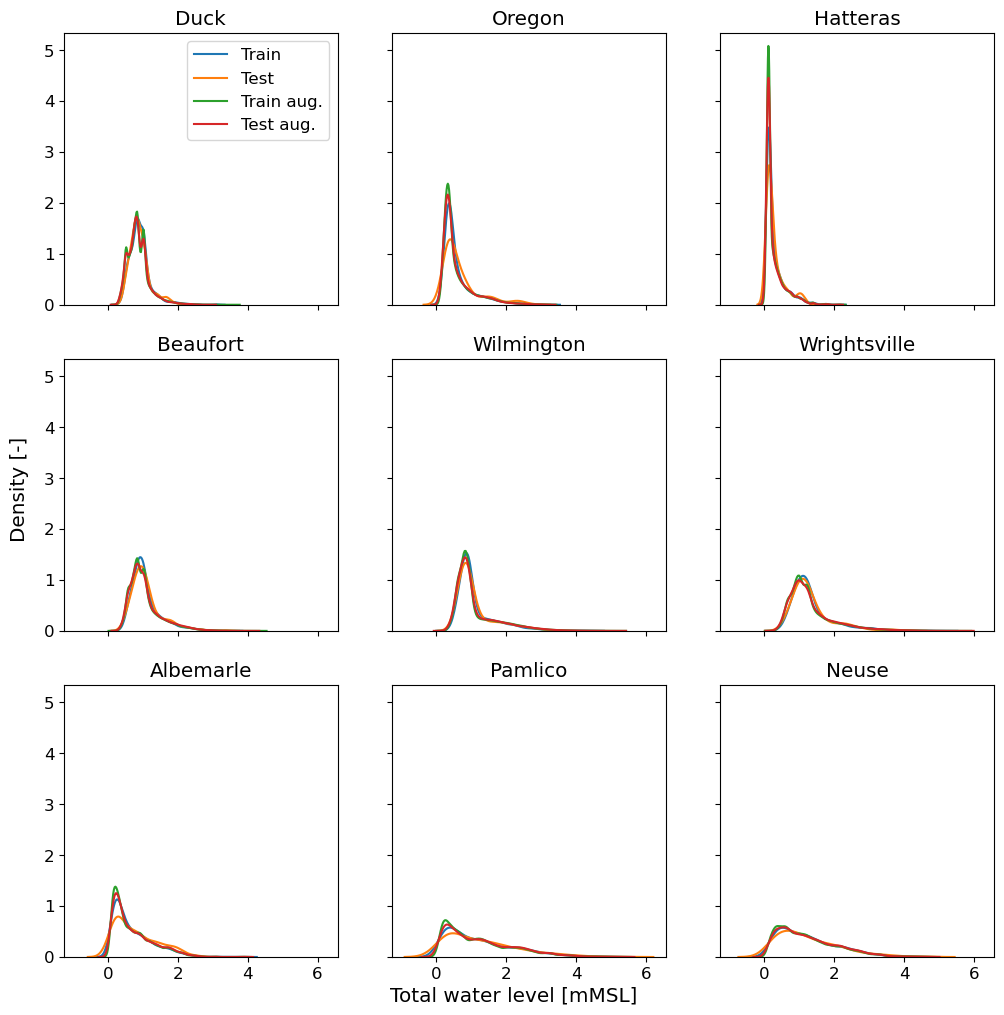

In [19]:
alpha = 1
fig, axs = plt.subplots(figsize = (12, 12), nrows = 3, ncols = 3, sharex = True, sharey = True)
for i in range(9):
    # print(stations[i])
    axi = axs.flatten()[i]
    # print(f'    max ytrain: {np.max(ytrain2[:, i, 0]):0.2f}')
    sns.kdeplot(dfytrain_real.iloc[:, i], ax = axi, alpha = alpha)
    # print(f'    max ytest: {np.max(ytest2[:, i, 0]):0.2f}')
    sns.kdeplot(dfytest_real.iloc[:, i], ax = axi, color = ccolors[1], alpha = alpha)
    # print(f'    max ytrainAug: {np.max(ytrainAug[:, i, 0]):0.2f}')
    sns.kdeplot(dfytrain_aug.iloc[:, i], ax = axi, color = ccolors[2], alpha = alpha)
    # print(f'    max ytestAug: {np.max(ytestAug[:, i, 0]):0.2f}')
    sns.kdeplot(dfytest_aug.iloc[:, i], ax = axi, color = ccolors[3], alpha = alpha)
    axi.set_title(stations[i])
    # axi.grid(alpha = 0.5)
    # axi.set_ylim([-0.1, 5.1])
    axi.set_xlabel('')
    axi.set_ylabel('')

axs[0, 0].legend(['Train', 'Test', 'Train aug.', 'Test aug.'], frameon = True, ncol = 1)
fig.supxlabel('Total water level [mMSL]', y=0.07)
fig.supylabel('Density [-]', x = 0.08)
fig.savefig(r'../models/NN/train_test_data/train_test_dataset_kde.png', dpi = 300, bbox_inches = 'tight')
# axs[0, 0].set_ylabel('Density [-]')
# axs[1, 0].set_ylabel('Density [-]')
# axs[2, 0].set_ylabel('Density [-]')
# axs[2, 0].set_xlabel('Total water level [mMSL]')
# axs[2, 1].set_xlabel('Total water level [mMSL]')
# axs[2, 2].set_xlabel('Total water level [mMSL]')

### Validation curves

In [20]:
def mean_bias(y_true, y_pred):
    return np.mean((y_true - y_pred))

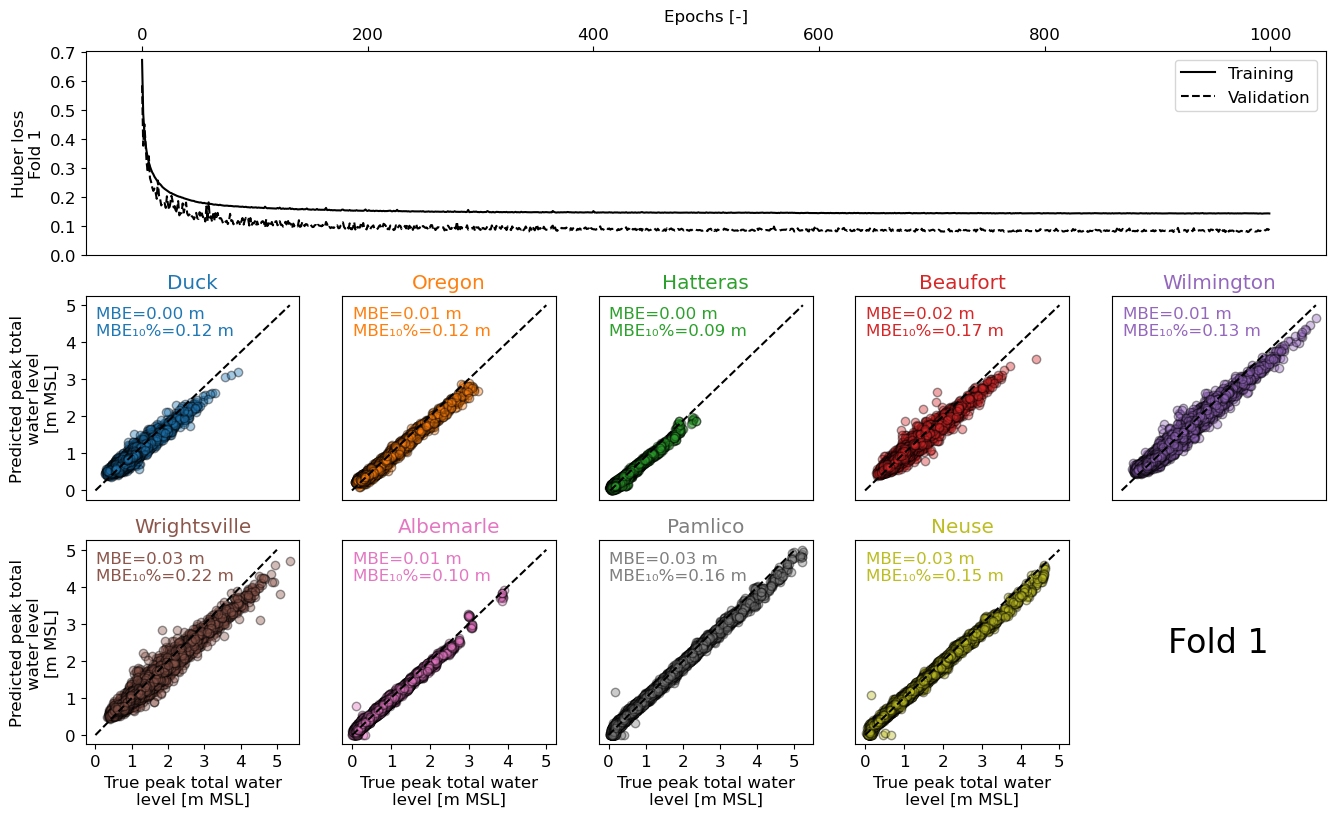

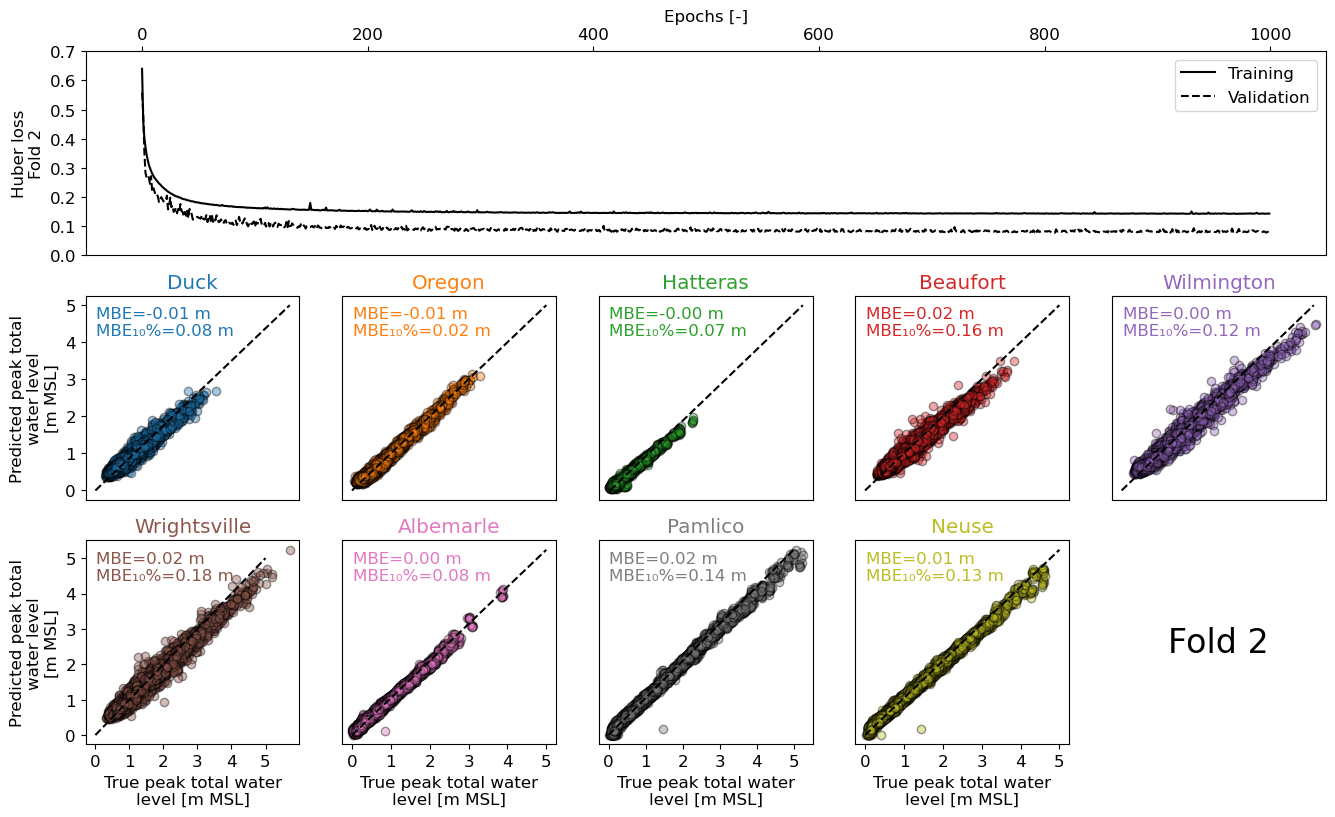

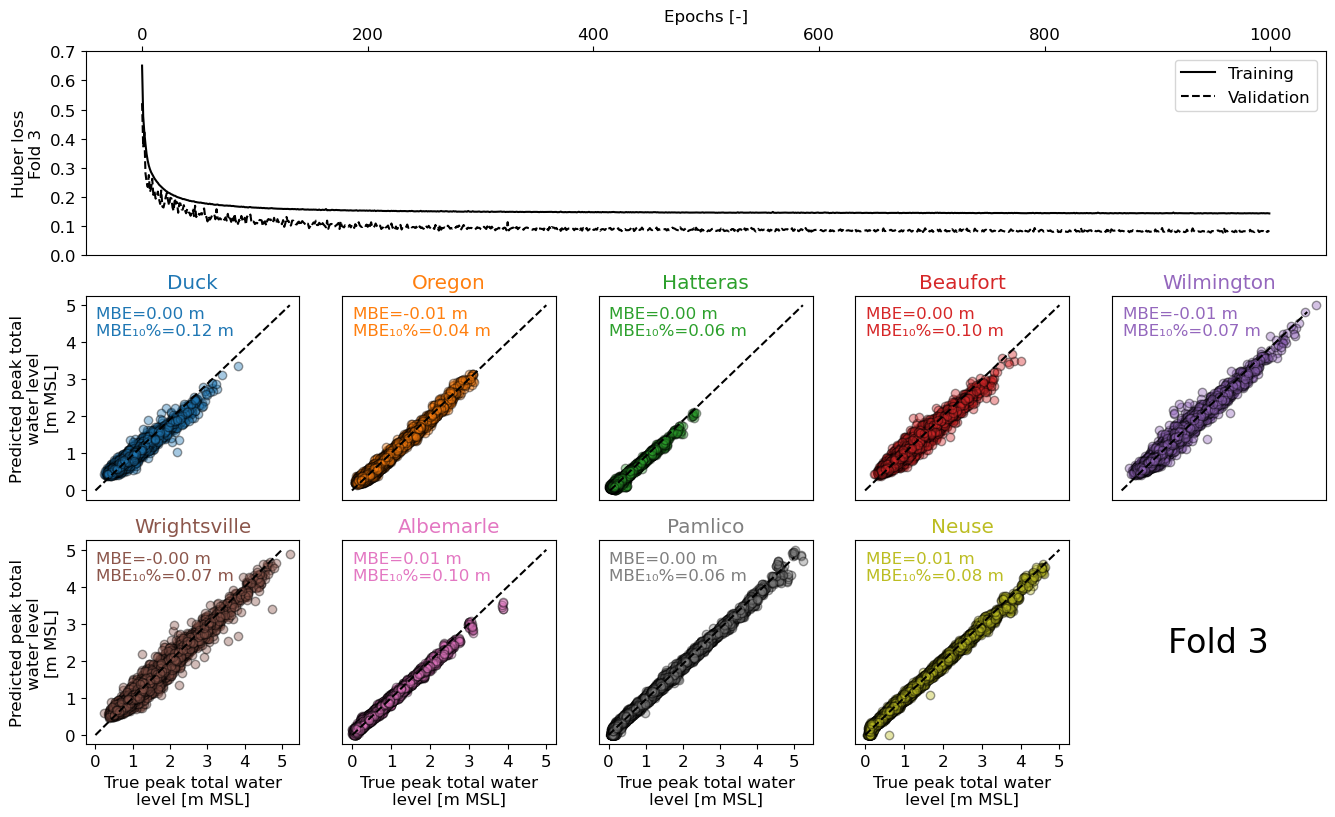

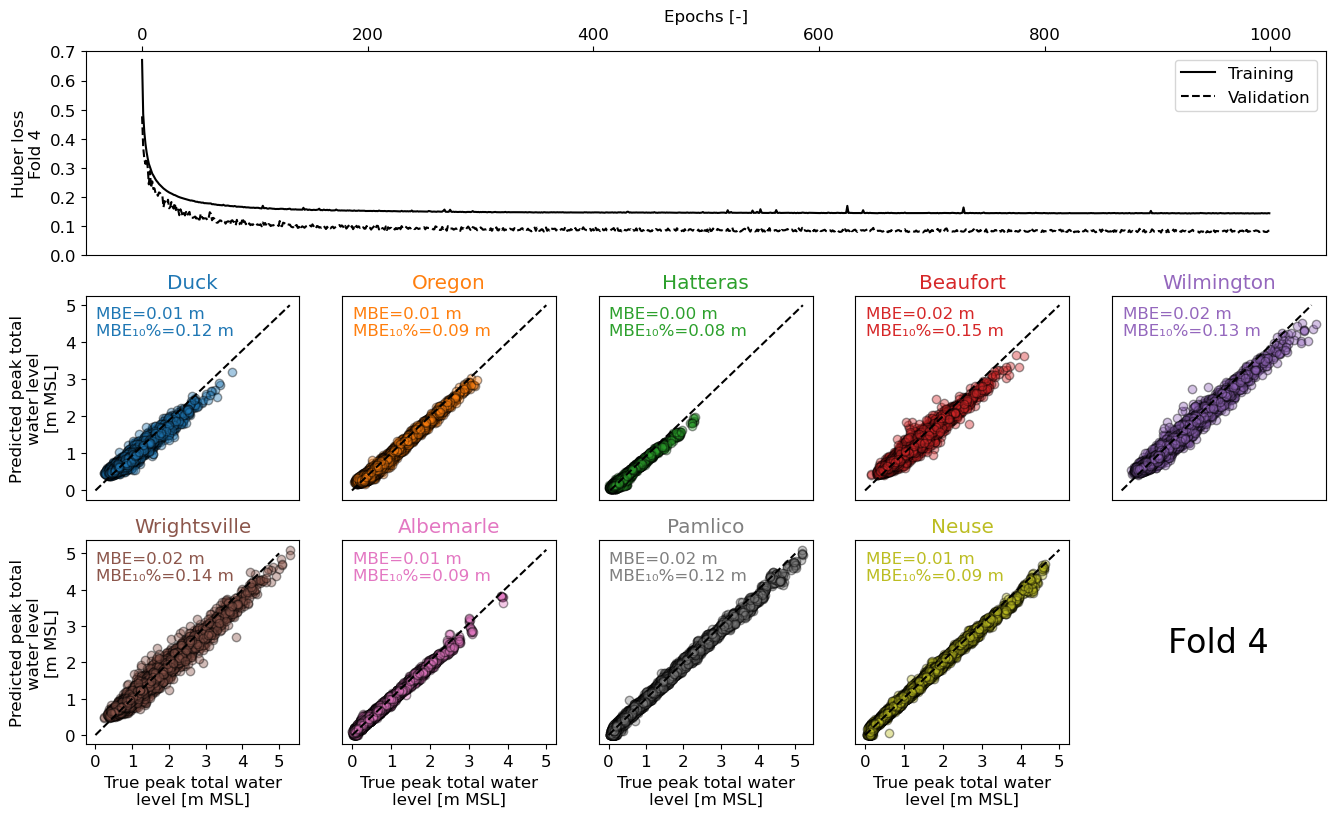

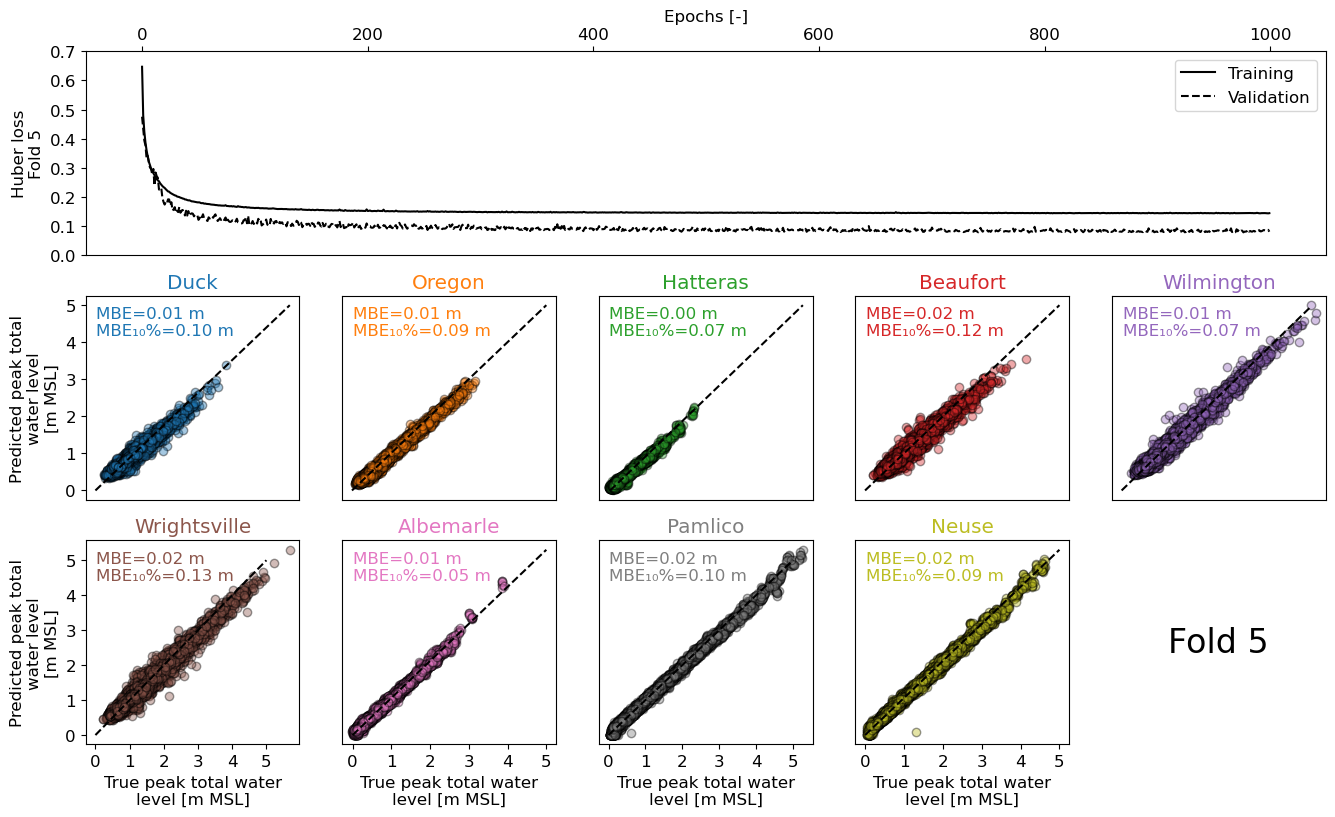

In [27]:
val_loss_sum, loss_sum = [], []

pathin = Path(r'../models/NN/09aan')
for fold in range(1, 6):

    hist = pd.read_csv(pathin/f'history_09aan_fold{fold}.csv', index_col = 0)
    val = pd.read_csv(pathin/f'val_set_predictions_09aan_fold{fold}.csv', index_col = 0)

    fig = plt.figure(figsize=(16, 9))
    grid = fig.add_gridspec(3, 5)

    ax0 = fig.add_subplot(grid[0, :])
    hist['rmse'].plot(ax = ax0, color = 'k', label = 'Training')
    hist['val_rmse'].plot(ax = ax0, color = 'k', label = 'Validation', ls = '--')
    ax0.legend(frameon = True)
    ax0.set_xlabel('Epochs [-]')
    ax0.set_ylabel(f'Huber loss\nFold {fold}')
    ax0.xaxis.tick_top()
    ax0.xaxis.set_label_position('top')
    ax0.set_yticks(np.arange(0, 0.8, 0.1))
    # ax0.grid(alpha = 0.5)

    for ic, c in enumerate(val.columns[:9]):
        if ic < 5:
            axi = fig.add_subplot(grid[1, ic])
            axi.axes.get_xaxis().set_visible(False)

        else:
            axi = fig.add_subplot(grid[2, ic-5])
            axi.set_xlabel('True peak total water\nlevel [m MSL]')

        axi.scatter(x = val[c], y = val[c.replace('true', 'pred')], color = ccolors[ic], 
                    alpha = 0.4, edgecolor = 'k')
        axi.plot(np.arange(0, 5.5, 0.5), np.arange(0, 5.5, 0.5), ls = '--', color = 'k')
        axi.set_xticks(np.arange(0, 6, 1))
        axi.set_yticks(np.arange(0, 6, 1))
        axi.axes.get_yaxis().set_visible(False)
        if ic == 0 or ic == 5:
            axi.axes.get_yaxis().set_visible(True)
            axi.set_ylabel('Predicted peak total\nwater level\n[m MSL]')
        
        axi.set_title(stations[ic], color = ccolors[ic])

        rmse_subscript = 'MBE\u2081\u2080\u0025'
        mbe0 = mean_bias(val[f'{c}'], val[c.replace('true', 'pred')])
        dummy = val.sort_values(by = f'{c}', ascending = False).iloc[:int(len(val)/10), :]
        mbe1 = mean_bias(dummy[f'{c}'], dummy[c.replace('true', 'pred')])
        axi.text(0.05, 0.95, f'MBE={mbe0:0.2f} m\n{rmse_subscript}={mbe1:0.2f} m', transform=axi.transAxes, fontsize=12,
                verticalalignment='top', color = ccolors[ic])
        if ic == 8:
            axi.text(1.7, 0.5, f'Fold {fold}', transform=axi.transAxes, fontsize=24,
                    color = 'k', horizontalalignment = 'center', verticalalignment = 'center')
    fig.savefig(f'../models/NN/09aan/_plots/validation_curve_fold{fold}.png', dpi = 300, bbox_inches = 'tight')
    # break

### Prediction for test set

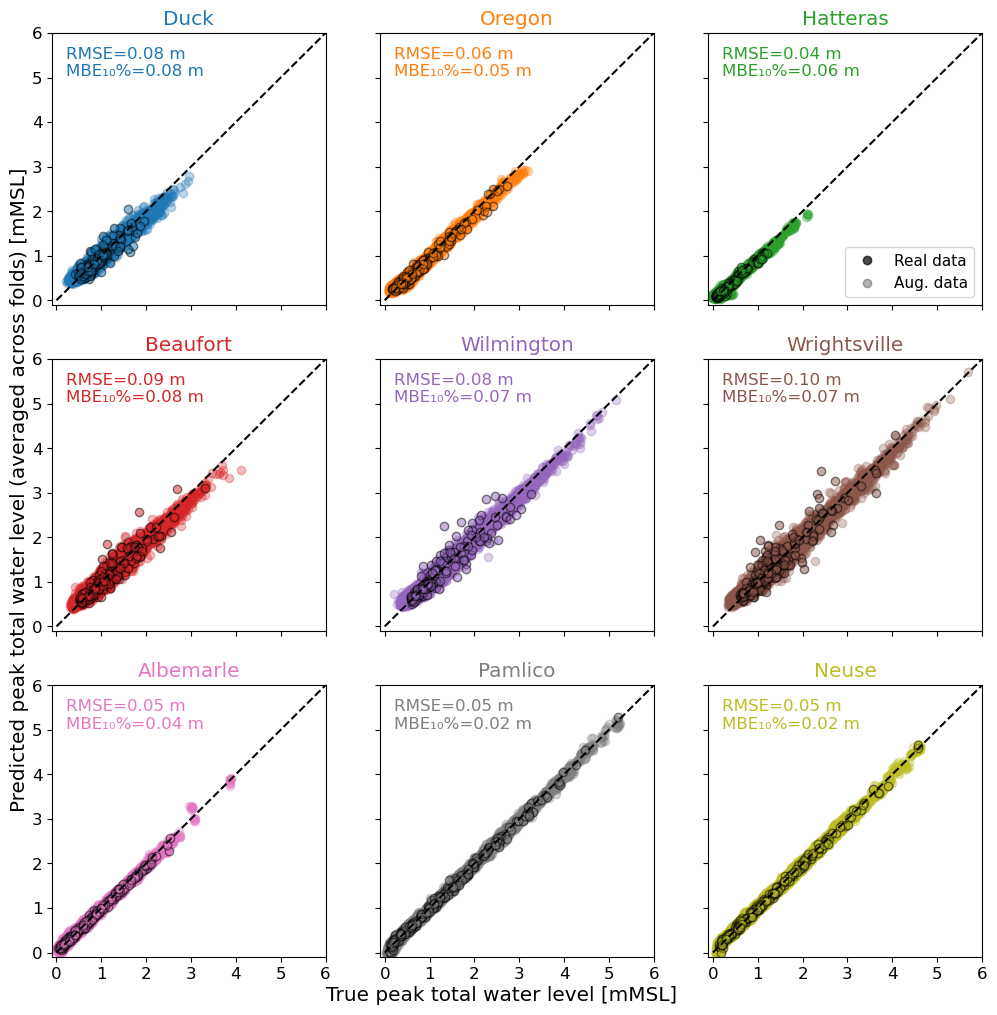

In [51]:
pathin = Path(r'../models/NN/09aan/prediction_for_test_set')
dfpred = []
for fold in range(1, 6):
    dummy = pd.read_csv(pathin/f'predTestSet_fold{fold}.csv', index_col = 0)
    dfpred.append(dummy)

dfpred = pd.concat(dfpred, axis=0, keys=range(len(dfpred)))
dfpred_mean = dfpred.groupby(level = 1).mean()
dfpred_std = dfpred.groupby(level = 1).std()

fig, axs = plt.subplots(figsize = (12, 12), nrows = 3, ncols = 3, sharex = True, sharey = True)
stations = ['duck', 'oregon', 'hatteras', 'beaufort', 'wilmington', 'wrightsville', 'albemarle', 'pamlico', 'neuse']

dfpred_mean_real = dfpred_mean.loc[ixtest[ixtest[0] <= 1813][0].index, :]
dfpred_mean_aug = dfpred_mean.loc[ixtest[ixtest[0] > 1813][0].index, :]

rmse_subscript = 'MBE\u2081\u2080\u0025'
binsAll = []
for ist, st, in enumerate(stations):
    ax = axs.flatten()[ist]
    ax.scatter(x = dfpred_mean_aug[f'{st}'], y = dfpred_mean_aug[f'{st}_pred'], color = ccolors[ist], alpha = 0.3)
    ax.scatter(x = dfpred_mean_real[f'{st}'], y = dfpred_mean_real[f'{st}_pred'], color = ccolors[ist], alpha = 0.5, edgecolor='k')

    dummy = ax.get_xticks()
    ax.set_xticks(np.arange(0, 7, 1))
    ax.set_yticks(np.arange(0, 7, 1))
    ax.set_xlim([-0.1, 6])
    ax.set_ylim([-0.1, 6])
    # print(dummy)
    binsAll.append(dummy)
    ax.plot(np.arange(0, 7, 1), np.arange(0, 7, 1), color = 'k', ls = '--')
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    rmse = np.sqrt(mean_squared_error(dfpred_mean[f'{st}'], dfpred_mean[f'{st}_pred']))

    dummy = dfpred_mean.sort_values(by = f'{st}', ascending = False).iloc[:int(len(dfpred_mean)/10), :]
    mbe = mean_bias(dummy[f'{st}'], dummy[f'{st}_pred'])
    ax.set_title(f'{st}'.capitalize(), color = ccolors[ist])#: RMSE = {rmse:0.2f} m', color = ccolors[ist])
    
    ax.text(0.05, 0.95, f'RMSE={rmse:0.2f} m\n{rmse_subscript}={mbe:0.2f} m', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', color = ccolors[ist])
    # ax.grid(alpha = 0.5)

handles = [Line2D([0], [0], color='k', label = 'Real data', marker = 'o', alpha = 0.7, markeredgecolor = 'k', ls = ' '),
        Line2D([0], [0], color='k', label = 'Aug. data', marker = 'o', alpha = 0.3, ls = ' ')]
axs[0, 2].legend(handles=handles, frameon = True, loc = 'lower right', fontsize = 11)

fig.supxlabel('True peak total water level [mMSL]', y=0.07)
fig.supylabel('Predicted peak total water level (averaged across folds) [mMSL]', x = 0.09)
fig.savefig(f'../models/NN/09aan/_plots/test_set_prediction_scatter_average_across_folds.png', dpi = 300, bbox_inches = 'tight')

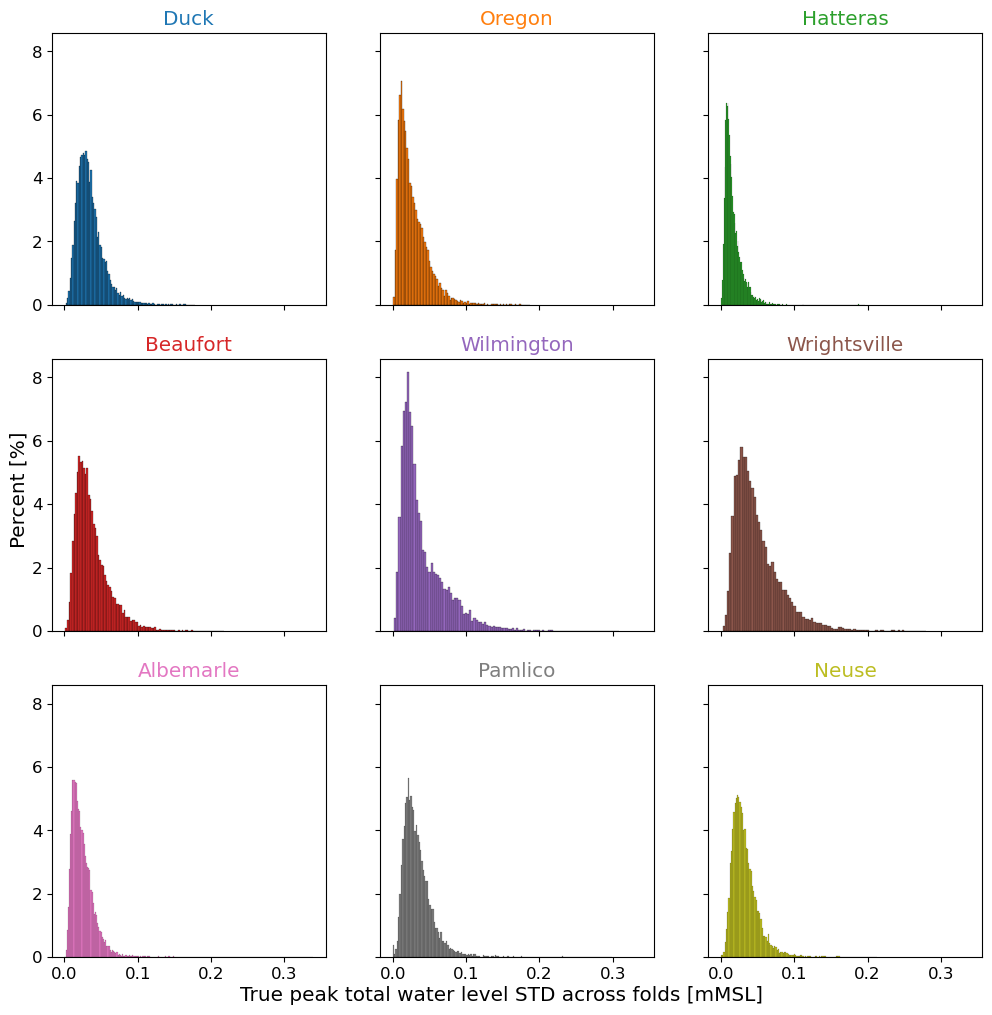

In [52]:
fig, axs = plt.subplots(figsize = (12, 12), nrows = 3, ncols = 3, sharex = True, sharey = True)

for ist, st, in enumerate(stations):
    ax = axs.flatten()[ist]
    sns.histplot(dfpred_std[f'{st}_pred'], color = ccolors[ist], alpha = 1, ax = ax, stat = 'percent')
    ax.set_title(f'{st}'.capitalize(), color = ccolors[ist])#: RMSE = {rmse:0.2f} m', color = ccolors[ist])
    ax.set_xlabel('')
    ax.set_ylabel('')


fig.supxlabel('True peak total water level STD across folds [mMSL]', y=0.07)
fig.supylabel('Percent [%]', x = 0.09)
fig.savefig(f'../models/NN/09aan/_plots/test_set_prediction_histogram_STD_across_folds.png', dpi = 300, bbox_inches = 'tight')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

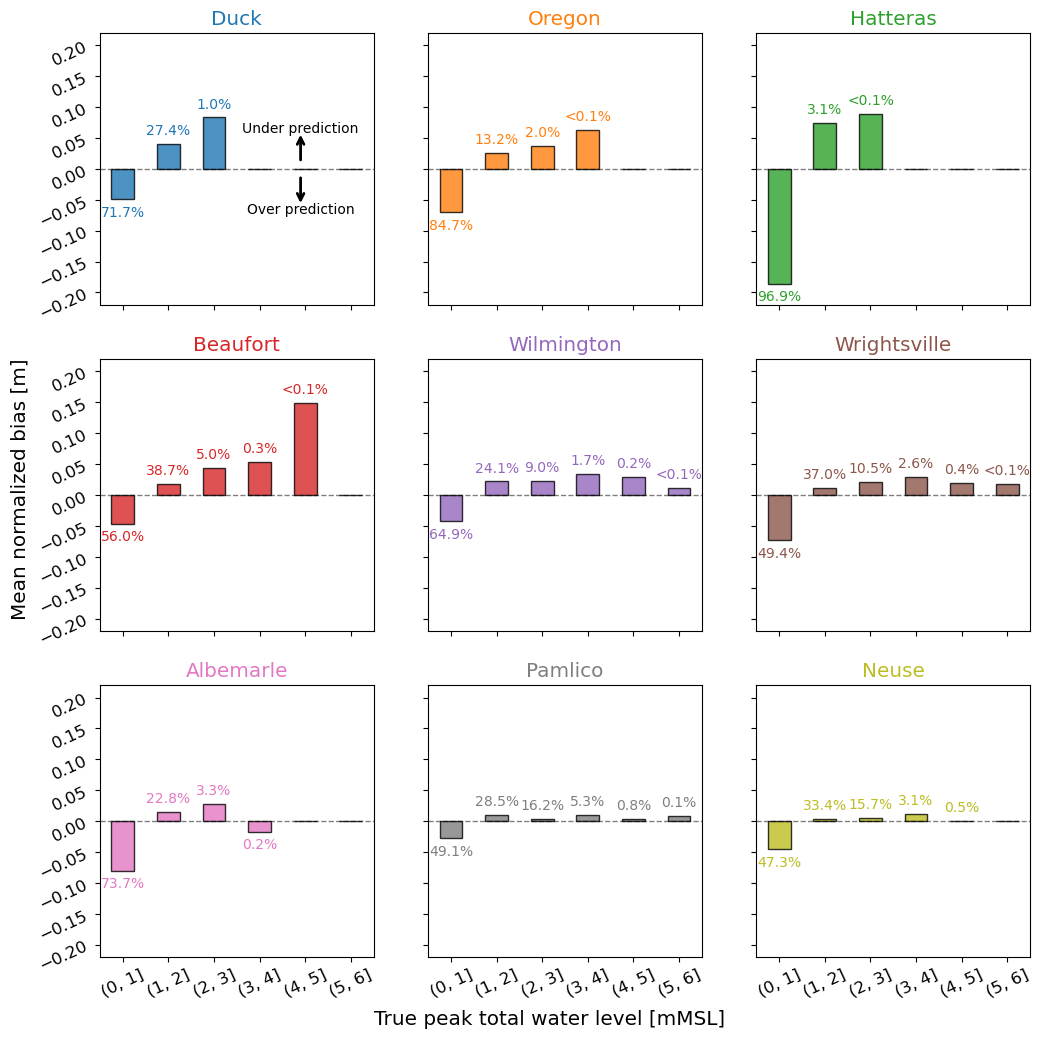

In [53]:
fig, axs = plt.subplots(figsize = (12, 12), nrows = 3, ncols = 3, sharex = True, sharey = True)

df = dfpred_mean.copy()

binsAll = []
for ist, st, in enumerate(stations):
    ax = axs.flatten()[ist]
    df[f'{st}_dif'] = (df[f'{st}'].values - df[f'{st}_pred'].values) / df[f'{st}'].values
    df[f'{st}_bins'] = pd.cut(df[f'{st}'], bins=np.arange(0, 7, 1))
    ax.axhline(y=0, color = 'k', alpha = 0.5, ls = '--', lw = 1)
    aux = df.loc[:, [x for x in df.columns if x.startswith(f'{st}')]].groupby(f'{st}_bins')[f'{st}_dif'].mean()
    aux.plot(kind = 'bar', ax = ax, color=ccolors[ist], edgecolor = 'k', alpha = 0.8)
    ax.set_title(f'{st}'.capitalize(), color = ccolors[ist])
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    ax.tick_params(labelrotation=25)
    dfper = df[f'{st}_bins'].value_counts() / df[f'{st}_bins'].value_counts().sum() * 100
    for j in ax.get_xticks():
        p = dfper.iloc[j]

        if aux.iloc[j] > 0:
            if p < 0.1:
                ax.text(j, aux.iloc[j]+0.01, '<0.1%', color = ccolors[ist], ha = 'center', fontsize = 10, va = 'bottom')
            else:
                ax.text(j, aux.iloc[j]+0.01, f'{p:0.1f}%', color = ccolors[ist], ha = 'center', fontsize = 10, va = 'bottom')
        else:
            if p < 0.1:
                ax.text(j, aux.iloc[j]-0.01, '<0.1%', color = ccolors[ist], ha = 'center', fontsize = 10, va = 'top')
            else:
                ax.text(j, aux.iloc[j]-0.01, f'{p:0.1f}%', color = ccolors[ist], ha = 'center', fontsize = 10, va = 'top')

    ax.set_ylim([-0.22, 0.22])
    ax.set_yticks(np.arange(-0.2, 0.25, 0.05))

ylabel = 'Mean normalized bias [m]'# (True - Pred)'
xlabel = 'True peak total water level [mMSL]'
fig.supxlabel(xlabel, y=0.05)
fig.supylabel(ylabel, x = 0.05)


props = dict(boxstyle='round', facecolor = 'white', alpha = 0)
x_arrow = 3.9  # X-coordinate for the arrow
y_arrow = 0.06    # Y-coordinate for the arrow, between 0 and 1
axs[0,0].text(x_arrow, 0.0, 'Under prediction\n\n\n\n\nOver prediction', fontsize=10,
        verticalalignment='center', bbox=props, horizontalalignment='center')
arrow_props = dict(facecolor='k', edgecolor='k', arrowstyle='->', linewidth=2)
axs[0, 0].annotate('', xy=(x_arrow, y_arrow), xytext=(x_arrow, 0.01),
                arrowprops=arrow_props)
axs[0, 0].annotate('', xy=(x_arrow, -1*y_arrow), xytext=(x_arrow, -0.01),
                arrowprops=arrow_props)
fig.savefig(f'../models/NN/09aan/_plots/test_set_prediction_barplot_mean_normalized_bias_.png', dpi = 300, bbox_inches = 'tight')